<a href="https://colab.research.google.com/github/marissawalker/data-quality-odw-2020/blob/master/LIGO_data_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example modified slightly from Duncan Macleod. The original script can be found here: https://gist.github.com/duncanmmacleod/66d903db1c005238e34ac76f9711c803

In [1]:
! pip install -q 'gwpy==1.0.1'

     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 2.7MB 16.9MB/s 


In [0]:
import glob
import os
import subprocess

from matplotlib import (pyplot, rcParams)
from matplotlib.animation import (FuncAnimation, writers)
from matplotlib.gridspec import GridSpec

from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

from gwosc.datasets import event_gps


rcParams.update({  # separate subplots more than the default
    'figure.subplot.hspace': .7,
    'figure.subplot.top': .95,
})

In [3]:
# set GPS times for data access, and for plotting
gps = event_gps('GW170817')

#gps = 1134294143.940 original scattering animation time
start = int(gps) - 32
end = int(gps) + 32
pstart = int(gps) - 10
pend = int(gps) + 10
ifo = 'L1' # original was H1 scattering

# get data 
data = TimeSeries.fetch_open_data(ifo, start, end, cache=True, verbose=True)

# clean data using bandpass and notch filtering
clean = data.bandpass(10, 200).notch(60).crop(pstart, pend)

# calculate ASD of quiet time
quiet = (int(gps) - 7, int(gps) - 1)
qasd = data.crop(*quiet).asd(fftlength=.5)

Fetched 1 URLs from www.gw-openscience.org for [1187008850 .. 1187008914))
Reading data... [Done]


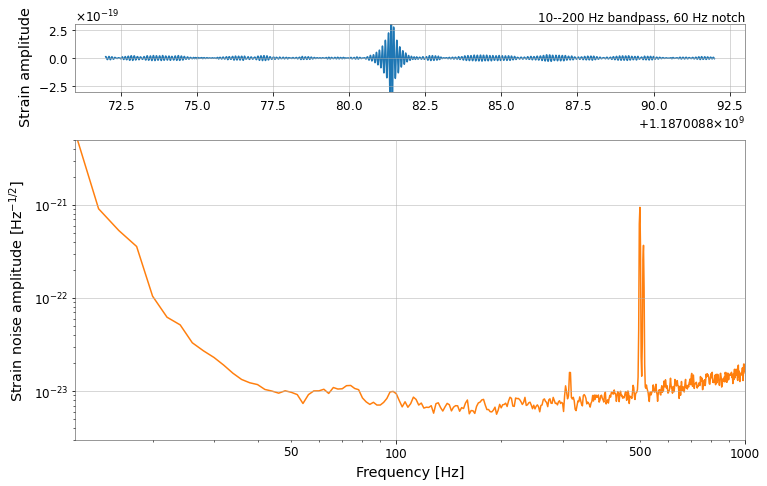

In [4]:
# initialise figure
plot = Plot(figsize=(12, 7))
grid = GridSpec(4, 1)
tax = plot.add_subplot(grid[:1]) # , projection='timeseries')
fax = plot.add_subplot(grid[1:]) #, projection='frequencyseries')

# plot time series
tax.plot(clean)
tax.set_ylim(-3e-19, 3e-19)
tax.set_ylabel('Strain amplitude', y=.38)

# create shaded box around the time series with duration 1.5 seconds
# This box will move during the animation to show the segment of the time series
# being used to generate the spectrum 
y1, y2 = tax.get_ylim() 
t = start
marker = tax.add_patch(pyplot.Polygon([(t, y1), (t+1.5, y1), (t+1.5, y2), (t, y2)],
                                       fc='lightgray', ec='r'))
tax.text(1., 1., '10--200 Hz bandpass, 60 Hz notch', ha='right', va='bottom',
          fontsize=12, transform=tax.transAxes)

# plot reference spectrum and initialise line for moving spectrum
line, = fax.plot([], [],)
fax.plot(qasd, zorder=0)
fax.set_xscale('log')
fax.set_xlim(12, 1000)
fax.set_yscale('log')
fax.set_ylim(3e-24, 5e-21)
fax.set_xlabel('Frequency [Hz]')
fax.set_ylabel(r'Strain noise amplitude [Hz$^{-1/2}$]')
fax.set_xticks([100, 1000])
fax.set_xticklabels(['100', '1000'])

start = float(int(gps) - 10)

In [0]:
def update(n):
    """Draw ASD and timestamp marker at each timestep
    """
    y1, y2 = tax.get_ylim()
    t = start + n * .5
    ts = data.crop(t, t+1.5)
    asd = ts.asd(fftlength=.5)
    marker.set_xy([(t, y1), (t+1.5, y1), (t+1.5, y2), (t, y2)])
    line.set_data(asd.xindex.value, asd.value)
    return marker, line

def init():
    line.set_data([], [])
    return line,



In [0]:
# make animation
nframes = 40
fps = 5.
delay = int(1 / fps * 1000)
anim = FuncAnimation(plot, update, init_func=init,frames=nframes,
                     interval=delay, blit=True)
writer = writers['ffmpeg'](fps=fps)
anim.save('data_animation.mp4', writer, dpi=600)

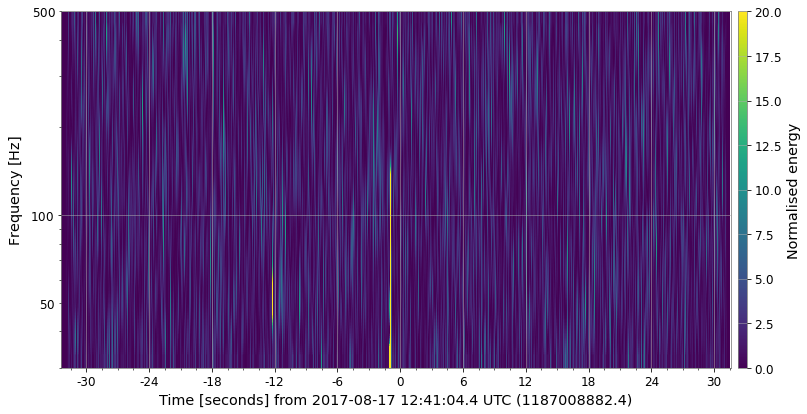

In [14]:
# make q transform of same data

qtrans = data.q_transform(frange=(30, 500),qrange=(4,64))
plot = qtrans.plot()
plot.colorbar(label="Normalised energy")
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot.colorbars[0].mappable.set_clim(0,20)



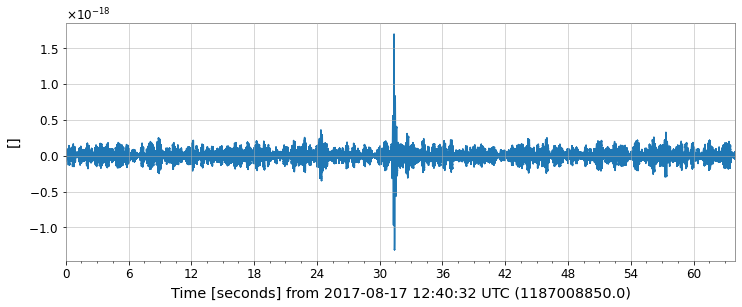

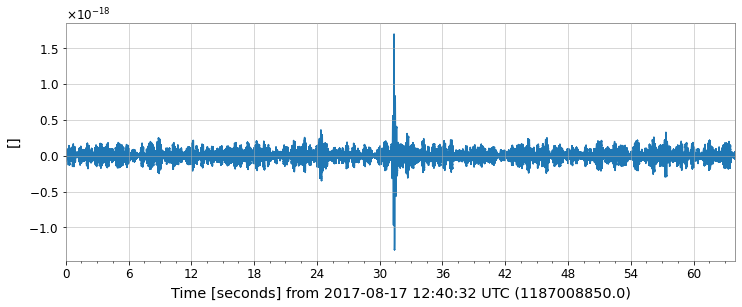

In [12]:
data.plot()